In [1]:
# - sorry about the messy notebook

import featuretools as ft
from dask import bag
from dask.diagnostics import ProgressBar
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import re
import multiprocessing
import pickle
cpus = multiprocessing.cpu_count()

np.random.seed(42)
ft.__version__

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool

In [ ]:
from bokeh.palettes import Spectral3

In [2]:
# read in the summary information and create the summary entity
# Again, note that we must use the TimeIndex type for the file date. 
# This will allow us to only use prior cases to predict this case. 
data_path = Path.cwd().parents[1] / 'ArrestCaseDataPipeline/DCSC-Scraper/'
summary_files = sorted(data_path.rglob("CMD_summary*.csv"))
summaries = pd.concat(pd.read_csv(f) for f in summary_files)
summaries = summaries.drop(columns=['Status_Date', 'Next_Event', 'Case_Status']).copy()
summaries['File_Date'] = pd.to_datetime(summaries['File_Date']).copy()
summaries['Hold_Out'] = summaries['File_Date'] > pd.to_datetime('12-31-2018')
hold_out_set = summaries[summaries['Hold_Out']]
training_set = summaries[~summaries['Hold_Out']]

In [ ]:
print(f"We have {len(hold_out_set)} cases in hold out set, {len(training_set)} cases in current training set. The size of training set will be reduced when the number of consumers is set")

In [3]:
# we'll need something like the following to filter all the dataframes: 

# The following function is to remove felony cases with detention events.
# Since we only consider CMD cases here, I didn't call it.
def remove_cases_with_detentions(df):
    df_copy = df.copy()
    df_copy["temp"] = df_copy["Result"].apply(lambda k: 1 if k in {'Preventive Detention', 'Defendant detained pending sentencing','Defendant Held in Other Jurisdiction'} else 0)
    pivot_df = df_copy.pivot_table(index="Case_ID", values="temp", aggfunc=np.sum)
    cases = set()
    for row in pivot_df.itertuples():
        if getattr(row, "temp"):
            cases.add(row.Index)
    return df[df["Case_ID"].isin(cases)]

In [5]:
num_party = 50000
party_files = data_path.rglob("CMD_party*.csv")
party = pd.concat(pd.read_csv(f) for f in party_files)
subsample_party = party['party_label'].sample(n=num_party, random_state=42)
party = party[party["Case_ID"].isin(training_set["Case_ID"])].reset_index(drop=True)
party = party[party['party_label'].isin(subsample_party)]
case_list = party["Case_ID"]
print(f"There are {len(case_list)} cases for {num_party} consumers in our training set")

There are 75741 cases for 50000 consumers in our training set


In [6]:
docket_files = sorted(data_path.rglob("CMD_docket*.csv"))
docket = pd.concat(pd.read_csv(f) for f in docket_files)
docket = docket.drop(columns=['Image_Avail','Docket_Index']).copy()
subsample_filter = docket['Case_ID'].isin(case_list)
docket = docket[subsample_filter].copy()

In [ ]:
len(docket)

In [ ]:
docket.tail(10)

In [7]:
# We start by reading in the docket bc we want to pull labels from it . 

docket['Date'] = pd.to_datetime(docket['Date'], errors='coerce').copy()
docket['fta'] = docket['Docket_Text'].str.contains('Defendant Failed to Appear') 
docket['fta'] = docket['fta'] * 1

In [ ]:
training_set = training_set[training_set["Case_ID"].isin(case_list)]
summaries = pd.concat([training_set, hold_out_set], ignore_index=True)
print(f"Now we have {len(hold_out_set)} cases in hold out set, {len(training_set)} cases in current training set.")

In [8]:
def extract_charge_type(k):
    try:
        return re.findall(r"Charge Filed Charge #?1: (.+)", k)[0]
    except IndexError as e:
        return np.nan
    except TypeError as e:
        return np.nan
docket["charge_type"] = docket["Docket_Text"].apply(extract_charge_type)
docket = docket.reset_index(drop=True)
docket.head()

Date                                        Docket_Text  \
0 2007-01-01  Charge Filed Charge #1: Poss of a Controlled S...   
1 2007-01-02  Event Scheduled Event: Misdemeanor Initial Sta...   
2 2007-01-02  Attorney Appointed/ Attorney SMITH, Mr JERRY R...   
3 2007-01-02  Event Resulted - Release Status: PR The follow...   
4 2007-01-02                                 Release Conditions   

           Case_ID fta                           charge_type  
0  2007 CMD 000005   0  Poss of a Controlled Substance -Misd  
1  2007 CMD 000005   0                                   NaN  
2  2007 CMD 000005   0                                   NaN  
3  2007 CMD 000005   0                                   NaN  
4  2007 CMD 000005   0                                   NaN

In [9]:
def extract_judge(k):
    """ TODO: this way will extract judge like COURTROOM C-10, which is apparently wrong.
    """
    try:
        return re.findall(r"^Event Scheduled Event.+Judge\:\s(.+)\sLocation", k)[0]
    except TypeError as e:
        return np.nan
    except IndexError as e:
        return np.nan

docket["judge"] = docket["Docket_Text"].apply(extract_judge)
docket = docket.reset_index(drop=True)
print(f"There are {docket.judge.notnull().sum()} event with judge's name specified in docket text")

There are 514393 event with judge's name specified in docket text


In [ ]:
docket.columns

In [10]:
# The number of events a defendant has to make in a court event appearance
check = docket[['Case_ID', 'Date']].drop_duplicates(subset=['Case_ID','Date'], keep='first')['Case_ID'].value_counts()

In [11]:
check.head()

2013 CMD 002190    104
2013 CMD 006058     95
2009 CMD 011614     89
2018 CMD 009670     86
2012 CMD 017022     84
Name: Case_ID, dtype: int64

In [12]:
case_freq = pd.DataFrame({'case': check.index, 'frequency': check.values})

In [180]:
#case_freq.describe()

In [ ]:
chart

In [14]:
arr_hist, edges = np.histogram(case_freq['frequency'], 
                               bins = int(110), 
                               range = [0, 110])
# Put the information in a dataframe
chart = pd.DataFrame({'case_count': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})
output_notebook()
# Create the blank plot
p = figure(plot_height = 600, plot_width = 600, 
           title = 'Distribution of court Case event appearance count',
          x_axis_label = 'Case Apprearance Count', 
           y_axis_label = 'Case Frequency')

# Add a quad glyph
p.quad(bottom=0, top=chart['case_count'], 
       left=chart['left'], right=chart['right'], 
       fill_color='red', line_color='black')



# Convert dataframe to column data source
src = ColumnDataSource(chart)
#src.data.keys()



# Add a quad glyph with source this time
p.quad(source = src, bottom=0, top='case_count', 
       left='left', right='right', 
       fill_color='red', line_color='black')



# Add a hover tool referring to the formatted columns
hover = HoverTool(tooltips = [('Number of Cases', '@left'),
                             ('Case Frequency', '@case_count')])

# Style the plot
#p = style(p)

# Add the hover tool to the graph
p.add_tools(hover)


show(p)

Loading BokehJS ...

In [ ]:
# Docket Event by Charges

In [ ]:
# The number of events a defendant has to make in a court event appearance
check = docket[['Case_ID', 'Date', 'charge_type']].drop_duplicates(subset=['Case_ID','Date'], keep='first')#['Case_ID']

In [133]:
check.to_excel('Increased Apps.xlsx')

In [15]:
ftas = docket[docket['fta'] == 1]

In [16]:
ftas.shape

(39059, 6)

In [18]:
ftas.head()

Date                                        Docket_Text  \
173 2007-03-08  Event Scheduled Event: Status Hearing Date: 03...   
176 2007-03-08  Defendant Failed to Appear DEFT. FTA FOR STATU...   
184 2007-03-21  Defendant Failed to Appear DEFT. FTA. FOR STAT...   
203 2007-01-01  Event Scheduled Event: Misdemeanor Initial Sta...   
209 2007-01-22  Defendant Failed to Appear. Bench warrant issu...   

             Case_ID fta charge_type                   judge  
173  2007 CMD 000022   1         NaN  MORRISON III, TRUMAN A  
176  2007 CMD 000022   1         NaN                     NaN  
184  2007 CMD 000022   1         NaN                     NaN  
203  2007 CMD 000025   1         NaN        RIGSBY, ROBERT R  
209  2007 CMD 000025   1         NaN                     NaN

In [19]:
ftas['charge_type'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: charge_type, dtype: object

In [20]:
# number of ftas per case
check_ftas = ftas[['Case_ID', 'Date']].drop_duplicates(subset=['Case_ID','Date'], keep='first')['Case_ID'].value_counts()

In [21]:
check_ftas

2009 CMD 000371    12
2018 CMD 014661    11
2014 CMD 004736    10
2016 CMD 018588    10
2013 CMD 000880    10
                   ..
2016 CMD 021234     1
2018 CMD 014233     1
2018 CMD 014430     1
2013 CMD 020335     1
2014 CMD 015738     1
Name: Case_ID, Length: 23327, dtype: int64

In [ ]:
chart.head()

In [127]:
edges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

In [131]:


case_freq = pd.DataFrame({'case': check_ftas.index, 'frequency': check_ftas.values})

arr_hist, edges = np.histogram(case_freq['frequency'], 
                               bins = int(15), 
                               range = [0, 15])
# Put the information in a dataframe
chart = pd.DataFrame({'case_count': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})

output_notebook()
# Create the blank plot
p = figure(plot_height = 600, plot_width = 600, 
           title = 'Distribution of FTA count',
          x_axis_label = 'FTA Count', 
           y_axis_label = 'FTA Frequency')

# Add a quad glyph
p.quad(bottom=0, top=chart['case_count'], 
       left=chart['left'], right=chart['right'], 
       fill_color='red', line_color='black')

src = ColumnDataSource(chart)
#src.data.keys()



# Add a quad glyph with source this time
p.quad(source = src, bottom=0, top='case_count', 
       left='left', right='right', 
       fill_color='red', line_color='black')



# Add a hover tool referring to the formatted columns
hover = HoverTool(tooltips = [('Number of FTAs', '@left'),
                             ('FTA Frequency', '@case_count')])

# Style the plot
#p = style(p)

# Add the hover tool to the graph
p.add_tools(hover)


show(p)

Loading BokehJS ...

In [23]:
check_ftas_f = pd.DataFrame({'Case_ID': check_ftas.index, 'ftas': check_ftas.values })

In [24]:
check_ftas_f.columns

Index(['Case_ID', 'ftas'], dtype='object')

In [25]:
check_ftas.shape

(23327,)

In [ ]:
# merge check ftas with charge type docket

In [26]:
fta_gb = check_ftas_f.groupby('ftas').size()

In [ ]:
# Incorporate Pie Chart Maybe

In [ ]:
inspect_ftas = ftas[['Case_ID', 'Date', 'Docket_Text', 'charge_type']].drop_duplicates(subset=['Case_ID','Date'], keep='first')

In [ ]:
#inspect_ftas.head(20)

In [28]:
docket_charge = docket.dropna(subset = ['charge_type'])

In [29]:
docket_charge.shape

(71383, 6)

In [30]:
docket_charge['charge_type'].nunique()

4687

In [31]:
docket_charge.columns

Index(['Date', 'Docket_Text', 'Case_ID', 'fta', 'charge_type', 'judge'], dtype='object')

In [ ]:
# Merge Data Frames - fta with available crime and FTA counts too

In [32]:
check_ftas_f.columns

Index(['Case_ID', 'ftas'], dtype='object')

In [175]:
#check_ftas_f.head(20)

In [34]:
merger = pd.merge(check_ftas_f, docket_charge, on = 'Case_ID', how = 'inner' )

In [36]:
merger.head()

Case_ID  ftas       Date  \
0  2009 CMD 000371    12 2009-01-06   
1  2018 CMD 014661    11 2018-10-05   
2  2014 CMD 004736    10 2014-03-20   
3  2016 CMD 018588    10 2016-11-14   
4  2016 CMD 018588    10 2016-11-14   

                                         Docket_Text fta  \
0        Charge Filed Charge #1: Sexual Solicitation   0   
1         Charge Filed Charge 1: Theft Second Degree   0   
2              Charge Filed Charge 1: Unlawful Entry   0   
3  Charge Filed Charge #1: Assault On A Police Of...   0   
4              Charge Filed Charge 1: Simple Assault   0   

                                         charge_type judge  
0                                Sexual Solicitation   NaN  
1                                Theft Second Degree   NaN  
2                                     Unlawful Entry   NaN  
3  Assault On A Police Officer Charge 1: Simple A...   NaN  
4                                     Simple Assault   NaN

In [37]:
print(merger['charge_type'].nunique())

2271


In [ ]:
# map charges

In [ ]:
#merger['charge_type'].value_counts().to_excel('Merged Frequency Counts.xlsx')

In [38]:
# Replacing charges now
# Aggregate different representations of top 6 charges

map_dict = {
    "Theft Second Degree Charge 1: Theft Second Degree": "Theft Second Degree",
    "Unlawful Entry Charge 1: Unlawful Entry": "Unlawful Entry",
    "Unlawful Entry - Private Property": "Unlawful Entry", 
    "Poss of a Controlled Substance -Misd Charge 2: Possession of Drug Paraphernalia": "Poss of a Controlled Substance -Misd",
    "Poss of a Controlled Substance -Misd Charge 1: Poss of a Controlled Substance -Misd": "Poss of a Controlled Substance -Misd",
    "Unlawful Entry Charge 1: Unlawful Entry - Private Property": "Unlawful Entry",
    "Shoplifting Charge 1: Shoplifting": "Shoplifting",
    "Poss of a Controlled Substance -Misd Charge 1: Poss of a Controlled Substance -Misd Charge 2: Possession of Drug Paraphernalia": "Poss of a Controlled Substance -Misd",
    "Sexual Solicitation Charge 1: Sexual Solicitation": "Sexual Solicitation",
    "Poss of a Controlled Substance -Misd Charge 1: Poss of a Controlled Substance -Misd Charge 2: Possession of Drug Paraphernalia": "Poss of a Controlled Substance -Misd"
    
    
    
}

In [39]:
merger.replace({"charge_type": map_dict}, inplace = True)

In [ ]:
#merger['charge_type'].value_counts().to_excel('Merged Frequency Counts2.xlsx')

In [40]:
top6_crime = ["Theft Second Degree","Poss of a Controlled Substance -Misd", "Unlawful Entry", "Bail Reform Act -Misd", "Simple Assault",
"Sexual Solicitation"]


In [41]:
merger_top6 = merger[['ftas','Case_ID','charge_type']].loc[merger['charge_type'].isin (top6_crime)]

In [42]:
merger_top6['charge_type'].nunique()

6

In [44]:
merger_top6.head()

ftas          Case_ID            charge_type
0    12  2009 CMD 000371    Sexual Solicitation
1    11  2018 CMD 014661    Theft Second Degree
2    10  2014 CMD 004736         Unlawful Entry
4    10  2016 CMD 018588         Simple Assault
5    10  2018 CMD 017504  Bail Reform Act -Misd

In [45]:
# Assess top charges 
gb_merger_top6 = merger_top6.groupby('ftas')['charge_type'].value_counts()

In [47]:
#gb_merger_top6

In [48]:
type(gb_merger_top6)

pandas.core.series.Series

In [49]:
gb_merger_test = merger_top6.groupby(['ftas', 'charge_type']).size()

In [51]:
#gb_merger_test

In [52]:
# check which is accurate


vax = merger_top6[(merger_top6['ftas'] == 1) & (merger_top6['charge_type'] == 'Bail Reform Act -Misd')]


In [53]:
vax.shape

(1319, 3)

In [ ]:
#gb_merger_test.__dict__

In [54]:
gb_flatten = gb_merger_test.reset_index(name = 'Count')

In [157]:
gb_flatten.to_excel("PieChartData.xlsx")

In [56]:
type(gb_flatten)

pandas.core.frame.DataFrame

In [57]:
pivot_flatten = gb_flatten.pivot(index = 'charge_type', columns = 'ftas', values = 'Count')

In [59]:
fin_pivot = pivot_flatten.reset_index()

In [60]:
fin_pivot

ftas                           charge_type       1      2      3      4     5  \
0                    Bail Reform Act -Misd  1319.0  570.0  199.0   88.0  37.0   
1     Poss of a Controlled Substance -Misd  1915.0  964.0  281.0  164.0  47.0   
2                      Sexual Solicitation   700.0  377.0   81.0   48.0  17.0   
3                           Simple Assault   955.0  383.0  129.0   46.0  30.0   
4                      Theft Second Degree  2055.0  927.0  321.0  127.0  43.0   
5                           Unlawful Entry  1709.0  802.0  263.0  148.0  49.0   

ftas     6     7    8    9   10   11   12  
0     12.0   5.0  1.0  1.0  1.0  NaN  NaN  
1     48.0  20.0  4.0  2.0  NaN  NaN  NaN  
2      8.0   1.0  2.0  NaN  NaN  NaN  1.0  
3     11.0   2.0  1.0  2.0  1.0  NaN  NaN  
4     19.0   9.0  3.0  2.0  NaN  1.0  NaN  
5     15.0   8.0  NaN  2.0  1.0  NaN  NaN

In [ ]:
len(fin_pivot)

In [ ]:
for i in range(len(fin_pivot)):
    print(list(fin_pivot.iloc[i,1:7]))


In [102]:
fta_list = ['1','2','3','4','5','6']
bail_reform = list(fin_pivot.iloc[0,1:7])
possession = list(fin_pivot.iloc[1,1:7])
sexual_sol = list(fin_pivot.iloc[2,1:7])
simple_assault = list(fin_pivot.iloc[3,1:7])
theft = list(fin_pivot.iloc[4,1:7])
unlawful_entry = list(fin_pivot.iloc[5,1:7])

In [103]:
print(fin_pivot['charge_type']) 

0                   Bail Reform Act -Misd
1    Poss of a Controlled Substance -Misd
2                     Sexual Solicitation
3                          Simple Assault
4                     Theft Second Degree
5                          Unlawful Entry
Name: charge_type, dtype: object


In [111]:
#print(bail_reform)
#unlawful_entry



In [172]:
from bokeh.core.properties import value
from bokeh.models import Range1d


crimes = ['Bail Reform','Possession (Controlled Substance)' , 'Sexual Solicitation','Simple Assault', 'Theft Second Degree', 'Unlawful Entry' ]

color_code = ['#800000', '#F0E68C', '#F052ff', '#442222', '#85d4ba', '#ff6a9c']

types_valuespec = [value(x) for x in crimes]
types_valuespec

# check out how to add interactivity for percentages
#https://github.com/bokeh/bokeh/blob/16e87ed63ca1aecaa42e93293f32d936685dcd3e/sphinx/source/docs/user_guide/examples/categorical_bar_stacked_hover.py

[{'value': 'Bail Reform'},
 {'value': 'Possession (Controlled Substance)'},
 {'value': 'Sexual Solicitation'},
 {'value': 'Simple Assault'},
 {'value': 'Theft Second Degree'},
 {'value': 'Unlawful Entry'}]

In [166]:
# Creating Data Source
data_source = {'FTAs': fta_list,
               'Bail Reform': bail_reform,
               'Possession (Controlled Substance)': possession,
               'Sexual Solicitation': sexual_sol,
                'Simple Assault': simple_assault,
               'Theft Second Degree': theft ,
               'Unlawful Entry': unlawful_entry
          }


In [106]:
data_source

{'FTAs': ['1', '2', '3', '4', '5', '6'],
 'Bail Reform': [1319.0, 570.0, 199.0, 88.0, 37.0, 12.0],
 'Possession (Controlled Substance)': [1915.0,
  964.0,
  281.0,
  164.0,
  47.0,
  48.0],
 'Sexual Solicitation': [700.0, 377.0, 81.0, 48.0, 17.0, 8.0],
 'Simple Assault': [955.0, 383.0, 129.0, 46.0, 30.0, 11.0],
 'Theft Second Degree': [2055.0, 927.0, 321.0, 127.0, 43.0, 19.0],
 'Unlawful Entry': [1709.0, 802.0, 263.0, 148.0, 49.0, 15.0]}

In [181]:
#Defining Figure
p = figure(x_range = fta_list,
           
           plot_width = 600,
           plot_height=600, 
           x_axis_label = 'FTA Count', 
           y_axis_label = 'FTA Frequency',
           
           title="FTA Frequency by Top 6 Charge Types"
          )

#output_notebook()
renderers = p.vbar_stack(stackers = crimes, 
             
             x = 'FTAs', 
             
             width=0.5, 
             
             source = data_source,
             
             color = color_code, 
             
             legend = types_valuespec
             
            )


#for r in renderers:
    



show(p)

In [174]:
# Pie Charts for first 3 FTAs drawn using Power BI

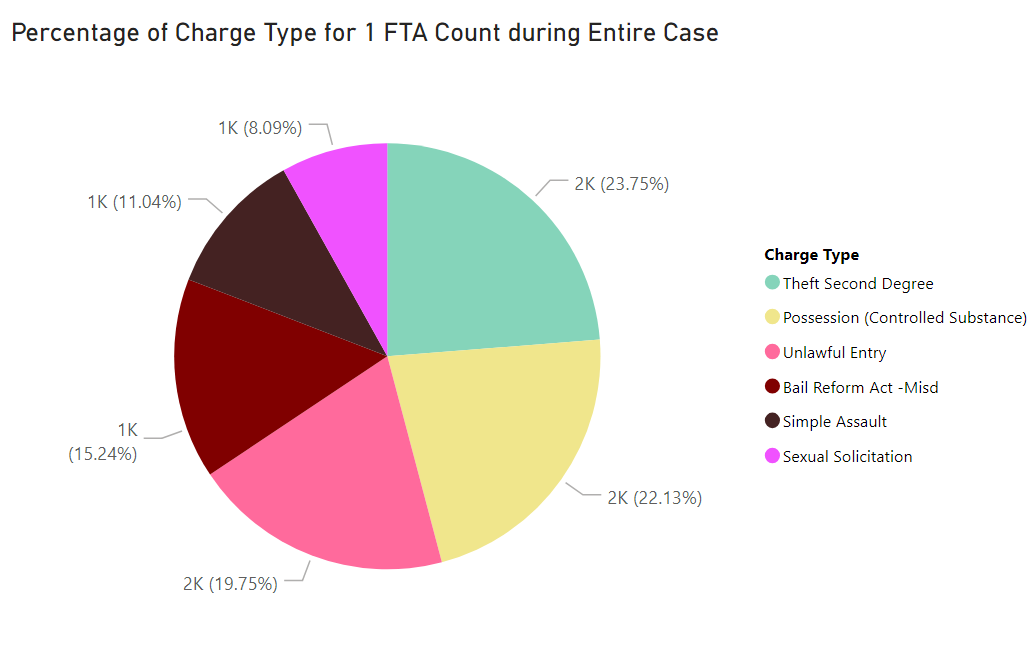

In [176]:
from IPython.display import Image
Image(filename="1fta.png")

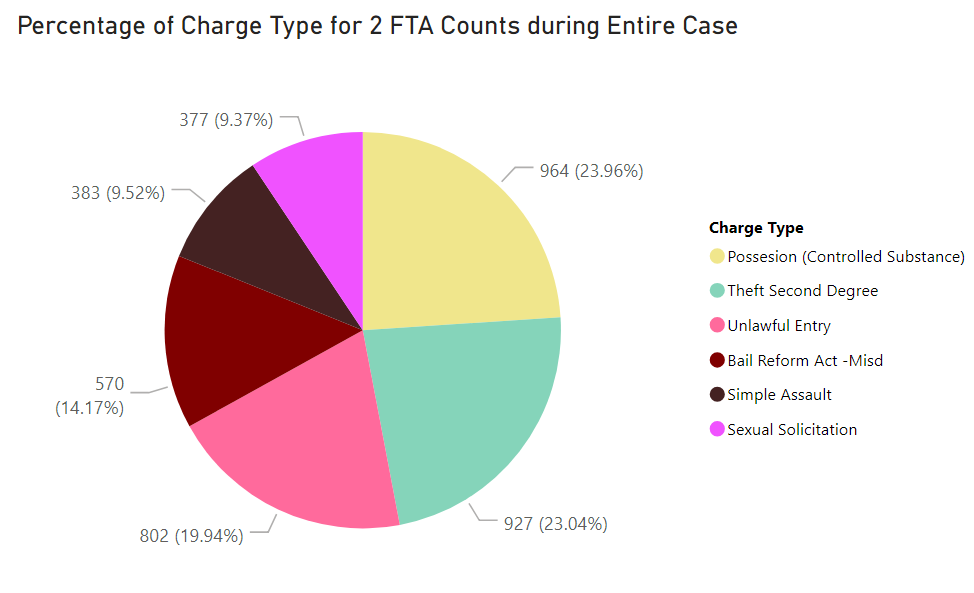

In [177]:
from IPython.display import Image
Image(filename="2fta.png")

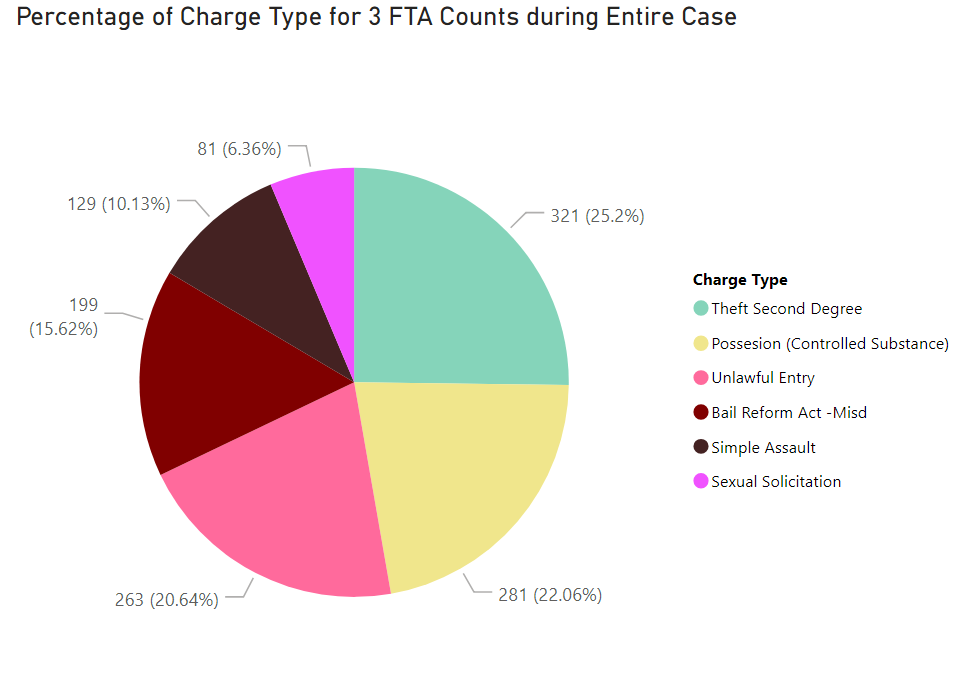

In [179]:
from IPython.display import Image
Image(filename="3fta.png")

In [ ]:
gb_merger_top6_f = pd.DataFrame({'Case_ID': check_ftas.index, 'ftas': check_ftas.values })

In [ ]:
# Inspect as a list
# 2009 CMD 000371(Highest FTA)
inspect_list = ['2009 CMD 000371']

In [ ]:
highest_appearance = docket[docket['Case_ID'] == '2013 CMD 002190']

In [ ]:
highest_appearance.to_excel("highest_appearance_events.xlsx")

In [134]:
case_freq.columns

Index(['case', 'frequency'], dtype='object')

In [155]:
case_freq.head(100)

case  frequency
0   2009 CMD 000371         12
1   2018 CMD 014661         11
2   2014 CMD 004736         10
3   2016 CMD 018588         10
4   2013 CMD 000880         10
..              ...        ...
95  2014 CMD 008190          7
96  2016 CMD 011079          7
97  2017 CMD 005464          7
98  2013 CMD 009016          7
99  2016 CMD 008847          7

[100 rows x 2 columns]

In [141]:
focus_cases = case_freq['case'][case_freq['frequency'] > 5]

In [143]:
focus_cases.shape

(237,)

In [144]:
type(focus_cases)

pandas.core.series.Series

In [146]:
highest_fta_appearances = docket[docket['Case_ID'].isin(focus_cases)]

In [147]:
highest_fta_appearances.shape

(33459, 6)

In [148]:
highest_fta_appearances.head()

Date                                        Docket_Text  \
8316 2007-01-19  Event Scheduled Event: Arraignment Date: 01/19...   
8317 2007-01-19  Attorney Appointed Attorney DC LAW STUDENTS IN...   
8318 2007-01-19             Charge Filed Charge #1: Simple Assault   
8319 2007-01-19             Charge Filed Charge #2: Simple Assault   
8320 2007-01-19  Event Resulted - Release Status: PR The follow...   

              Case_ID fta     charge_type               judge  
8316  2007 CMD 001644   0             NaN  BRENNEMAN, DIANE M  
8317  2007 CMD 001644   0             NaN                 NaN  
8318  2007 CMD 001644   0  Simple Assault                 NaN  
8319  2007 CMD 001644   0             NaN                 NaN  
8320  2007 CMD 001644   0             NaN                 NaN

In [149]:
highest_fta_appearances.to_excel('Review_Cases.xlsx')

In [ ]:
#docket[docket['Docket_Text'].str.contains('Charge #3:', na = " ")]

In [ ]:
print(docket['charge_type'].nunique())

In [ ]:
#docket['charge_type'].value_counts().to_excel('Charge Frequency Counts.xlsx')

In [ ]:
docket.shape

In [ ]:
check = docket[['Case_ID', 'Date']].drop_duplicates(subset=['Case_ID','Date'], keep='first')

In [ ]:
type(check)

In [ ]:
check.tail(30)

In [ ]:
gb = check.groupby(['Case_ID'])

In [ ]:
print(gb.head())

In [ ]:
key_list_from_gb = ['2009 CMD 001411', '2009 CMD 001390']


map = {}
for key, values in gb:
    if key in key_list_from_gb:
        arr = map.get(key,[])
        arr.append(values['Date'])
        map.update({key:arr})
            
#         print(gb.get_group(key), "\n")
for key, values in map.items():
    temp = list(values)
    print(temp[0])

#print(map)
        
        

In [ ]:
case_ids = []
start_date = []
last_date = []

for case_id in gb:
     if key in key_list_from_gb:
            print (case_ids.append(case_id.iloc[1,0]['Case_ID']))
            start_date.append(case_id[1].iloc[1,1]['Date']) 
            last_date.append(case_id[1].iloc[-1,1])['Date']

# creating dataframe
case_duration = pd.DataFrame({'case_ID': case_ids,
                             'start_date': start_date,
                             'end_date': last_date})            

In [ ]:
case_duration

In [ ]:
# Duration of Cases in Days

period = docket.groupby('Case_ID').head(2)

In [ ]:
# for key, item in gb:
#     print(gb.get_group(key), "\n\n")

In [ ]:
period

In [ ]:
charges.shape

In [ ]:
charges.head(20)

In [ ]:
# Give a stacked bar chart of cases where there were previous FTAs to see if particular misdemenors were prone to FTAs


In [ ]:
# write function to anlalyze by parameters by charge type and maybe date
# check out notebook from which failure to show was developed



In [ ]:
# FTA Trends Across Years


# Creating Functions to make plots

def make_barplot(dataframe, x_range, value, tool_tips, title, x_axis, y_axis):
    """
    Plots Bar chart
    """
    
    src = ColumnDataSource(dataframe)
    tooltips = tool_tips

    # define plot figure
    p = figure(x_range= dataframe[x_range], 
               plot_height=600,
               plot_width = 900,
               title=title,
               x_axis_label = x_axis,
               y_axis_label = y_axis,
               tooltips = tooltips, 
               toolbar_location=None
              )
    p.vbar(x=x_range,
           top=value,
           width=0.5,
           color = 'indianred',
           source = src,
           bottom=0,)
        
    show(p)
    
def make_stackedplot(dataframe, x_range, tool_tips, title, x_axis, y_axis, stackers):
    """
    Plots stacked bars
    """
    
    src = ColumnDataSource(dataframe)
    tooltips = tool_tips

    # define plot figure
    p = figure(x_range= dataframe[x_range], 
               plot_height=600,
               plot_width = 900,
               title=title,
               x_axis_label = x_axis,
               
               y_axis_label = y_axis,
               tooltips = tooltips, 
               toolbar_location=None)

    p.vbar_stack(stackers, 
                 x = x_range, 
                 width=0.5, 
                 color = ['indianred', 'green'],
                 
                 source = src)
        
    p.xaxis.major_label_orientation = math.pi/3
    
    show(p)

In [ ]:
# Walk through particular cases
# Contextualize it - Has to make sense about someone who doesn't know anything about your topic
# The answer and how you got there
# Communicate why
# What are your results - understand why
# What do the features mean
# How do you know that what you're seeing her isn't conflated - separate in buckets
# Convince that it is hypothetically valid
# You're not confounded
# Are you including the dat
# What does the result mean?

#Preliminary answers in the next 2 days
# Find cases with differnet lengths of dockets so you can talk about it
# What does it mean and why - context#
#charge type docket length
#docket length and day of the week


# What distinguishes the long tail?
# We can't use the docket count??? - Can we have an impact with the intervention

# Tell a story about the problem on docket events
# descriptive graph
# What does the data mean in the context of the problem

# Distinction small dockets and large dockets - what does it mean intuitively for failure to appear
# Can you verify that by looking at failure to appear


# Histogram in bucket of 10 days
# What does this mean and how can we improve our systems
# Tell how it's useful

